# Image Classification and Regression 

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import keras.utils as np_utils
# On some implementations of matplotlib, you may need to change this value
IMAGE_SIZE = 72

Using TensorFlow backend.


## Simple Classification

In [0]:
def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)


def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]


In [0]:

def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in range(nb_samples):
        if i % 100 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    Y_test = np_utils.to_categorical(Y_test, 3) 
    return [X_test, Y_test]

In [0]:

def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 100 == 0:
            print(i)
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

import matplotlib.patches as patches

def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    return [X_test, Y_test]

In [0]:

def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()

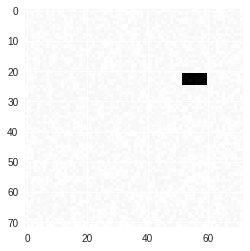

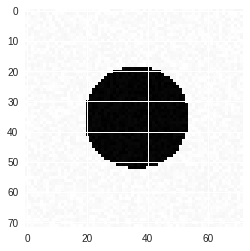

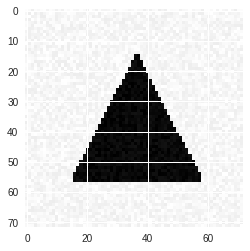

In [6]:
im = generate_a_rectangle(10, True)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.show()

im = generate_a_disk(10)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.show()

[im, v] = generate_a_triangle(20, False)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.show()


In [0]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization, UpSampling2D
from keras.optimizers import SGD, Adam
from keras.utils import to_categorical

In [8]:
# Generating the training dataset
[X_train, Y_train] = generate_dataset_classification(300, 20)


Creating data:
0
100
200


In [0]:
Y_train_categorical = to_categorical(Y_train, num_classes=3)
model = Sequential()

model.add(Dense(3, input_dim=5184, kernel_initializer='normal'))
model.add(Dense(3, kernel_initializer='normal', activation='sigmoid'))

sgdOptimizer = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)

model.compile(loss='categorical_crossentropy', optimizer=sgdOptimizer, metrics=['accuracy'])
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, Y_train_categorical, validation_split=0.1, epochs=50, batch_size=16, verbose=1)


Train on 270 samples, validate on 30 samples
Epoch 1/50
270/270 [==============================] - 0s 1ms/step - loss: 1.0882 - acc: 0.4778 - val_loss: 1.0881 - val_acc: 0.4667
Epoch 2/50
270/270 [==============================] - 0s 122us/step - loss: 1.0800 - acc: 0.5481 - val_loss: 1.0791 - val_acc: 0.5000
Epoch 3/50
270/270 [==============================] - 0s 128us/step - loss: 1.0675 - acc: 0.5889 - val_loss: 1.0625 - val_acc: 0.5667
Epoch 4/50
270/270 [==============================] - 0s 123us/step - loss: 1.0455 - acc: 0.5852 - val_loss: 1.0401 - val_acc: 0.5667
Epoch 5/50
270/270 [==============================] - 0s 122us/step - loss: 1.0119 - acc: 0.5889 - val_loss: 0.9981 - val_acc: 0.5333
Epoch 6/50
270/270 [==============================] - 0s 126us/step - loss: 0.9606 - acc: 0.6185 - val_loss: 0.9713 - val_acc: 0.5667
Epoch 7/50
270/270 [==============================] - 0s 126us/step - loss: 0.8999 - acc: 0.6370 - val_loss: 0.8458 - val_acc: 0.6667
Epoch 8/50
270/270 

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


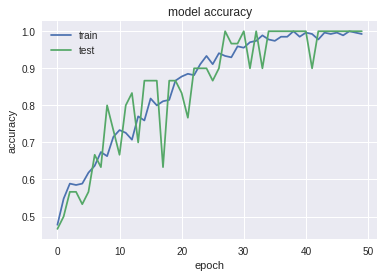

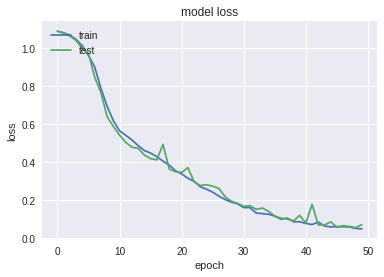

In [0]:
# TODO: Plots of loss and accuracy, SGD and Adam
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
X_test = generate_a_disk(10)
X_test = X_test.reshape(1, X_test.shape[0])
model.predict(X_test)

array([[1., 1., 0.]], dtype=float32)

## Visualization of the Solution

In [0]:
print(model.get_weights()[0].shape)
print(len(model.get_weights()))

(5184, 3)
4


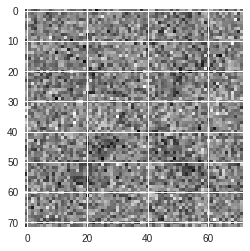

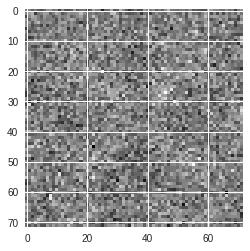

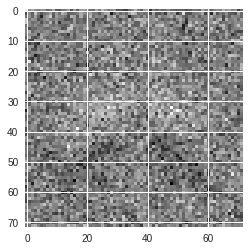

In [0]:
for j in range(3):
    plt.imshow(model.get_weights()[0][:,j].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
    plt.show()

## A More Difficult Classification Problem

In [0]:
[X_train, Y_train] = generate_dataset_classification(300, 20, True)

Creating data:
0
100
200


In [0]:
[X_test, Y_test] = generate_test_set_classification()

Creating data:
0
100
200


In [0]:
Y_train_categorical = to_categorical(Y_train, num_classes=3)
Y_test_categorical = to_categorical(Y_test, num_classes=3)
model = Sequential()

model.add(Dense(3, input_dim=5184, kernel_initializer='normal'))
model.add(Dense(3, kernel_initializer='normal', activation='sigmoid'))

sgdOptimizer = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)

model.compile(loss='categorical_crossentropy', optimizer=sgdOptimizer, metrics=['accuracy'])
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, Y_train_categorical, validation_data=(X_test, Y_test), epochs=50, batch_size=8, verbose=2)

Train on 300 samples, validate on 300 samples
Epoch 1/50
 - 0s - loss: 1.0954 - acc: 0.3300 - val_loss: 1.0959 - val_acc: 0.3133
Epoch 2/50
 - 0s - loss: 1.0925 - acc: 0.3100 - val_loss: 1.0936 - val_acc: 0.3333
Epoch 3/50
 - 0s - loss: 1.0915 - acc: 0.3200 - val_loss: 1.0890 - val_acc: 0.3400
Epoch 4/50
 - 0s - loss: 1.0851 - acc: 0.3633 - val_loss: 1.0875 - val_acc: 0.3300
Epoch 5/50
 - 0s - loss: 1.0811 - acc: 0.3433 - val_loss: 1.0776 - val_acc: 0.3800
Epoch 6/50
 - 0s - loss: 1.0773 - acc: 0.3867 - val_loss: 1.0732 - val_acc: 0.4900
Epoch 7/50
 - 0s - loss: 1.0716 - acc: 0.4100 - val_loss: 1.0600 - val_acc: 0.4000
Epoch 8/50
 - 0s - loss: 1.0625 - acc: 0.3833 - val_loss: 1.0658 - val_acc: 0.3733
Epoch 9/50
 - 0s - loss: 1.0494 - acc: 0.4267 - val_loss: 1.0328 - val_acc: 0.4367
Epoch 10/50
 - 0s - loss: 1.0326 - acc: 0.4500 - val_loss: 1.0148 - val_acc: 0.5333
Epoch 11/50
 - 0s - loss: 1.0233 - acc: 0.4600 - val_loss: 0.9908 - val_acc: 0.5300
Epoch 12/50
 - 0s - loss: 0.9912 - acc:

In [0]:
model.evaluate(X_test, Y_test)

300/300 [==============================] - 0s 63us/step


[0.8427144304911296, 0.5466666662693024]

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


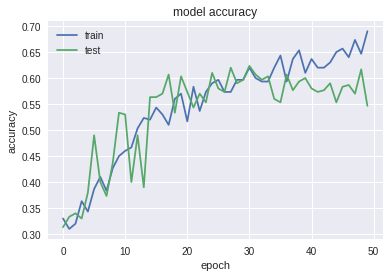

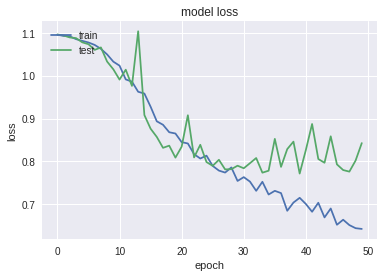

In [0]:
# TODO: Plots of loss and accuracy, SGD and Adam
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
nb_sample = 1000
[X_train, Y_train] = generate_dataset_classification(nb_sample, 20, True)
Y_train_categorical = np_utils.to_categorical(Y_train, num_classes=3)
[X_test, Y_test] = generate_test_set_classification()
Y_test_categorical = np_utils.to_categorical(Y_test, num_classes=3)
X_test = X_test.reshape((300,IMAGE_SIZE,IMAGE_SIZE,1))

Creating data:
0
100
200
300
400
500
600
700
800
900
Creating data:
0
100
200


In [0]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

def createModel():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(IMAGE_SIZE,IMAGE_SIZE,1)))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(3, activation='softmax'))
    return model

cnn_model = createModel()


X_train = X_train.reshape((nb_sample,IMAGE_SIZE,IMAGE_SIZE,1))

cnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = cnn_model.fit(X_train, Y_train_categorical, validation_data=(X_test,Y_test), epochs=10, batch_size=36, verbose=1)

Train on 1000 samples, validate on 300 samples
Epoch 1/10
1000/1000 [==============================] - 26s 26ms/step - loss: 1.3582 - acc: 0.5090 - val_loss: 0.8213 - val_acc: 0.6033
Epoch 2/10
1000/1000 [==============================] - 24s 24ms/step - loss: 0.6314 - acc: 0.7320 - val_loss: 0.6059 - val_acc: 0.7367
Epoch 3/10
1000/1000 [==============================] - 24s 24ms/step - loss: 0.3495 - acc: 0.8870 - val_loss: 0.3461 - val_acc: 0.8700
Epoch 4/10
1000/1000 [==============================] - 24s 24ms/step - loss: 0.1440 - acc: 0.9600 - val_loss: 0.2324 - val_acc: 0.9100
Epoch 5/10
1000/1000 [==============================] - 25s 25ms/step - loss: 0.0665 - acc: 0.9820 - val_loss: 0.2309 - val_acc: 0.9167
Epoch 6/10
1000/1000 [==============================] - 25s 25ms/step - loss: 0.0287 - acc: 0.9960 - val_loss: 0.2074 - val_acc: 0.9333
Epoch 7/10
1000/1000 [==============================] - 24s 24ms/step - loss: 0.0227 - acc: 0.9970 - val_loss: 0.2040 - val_acc: 0.9400
E

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


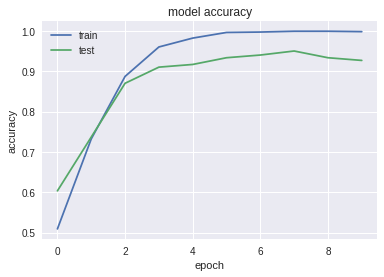

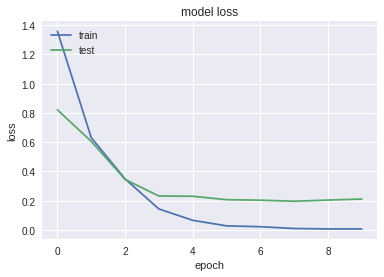

In [0]:
# TODO: Plots of loss and accuracy, SGD and Adam
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
cnn_model.evaluate(X_test, Y_test)

300/300 [==============================] - 2s 5ms/step


[0.21194015979766845, 0.926666665871938]

## A Regression Problem

In [87]:
nb_samples = 900
[X_train, Y_train] = generate_dataset_regression(nb_samples, 20)
[X_test, Y_test] = generate_test_set_regression()
print(Y_train.shape)

Creating data:
0
100
200
300
400
500
600
700
800
Creating data:
0
100
200
(900, 6)


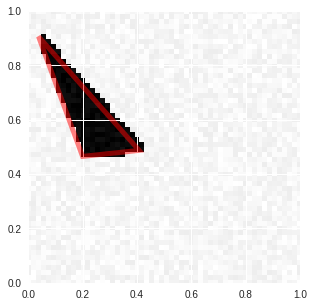

[0.40798921 0.48723003 0.19998412 0.46506003 0.0380623  0.90598046]


In [88]:
visualize_prediction(X_train[0], Y_train[0])
print(Y_train[0])

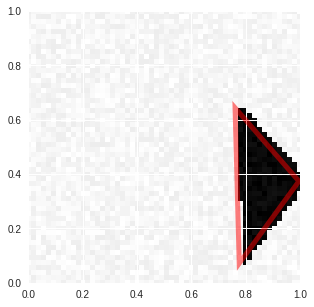

Ytrain:  [0.76112508 0.64364612 0.77642817 0.0716809  0.99600466 0.37382116]
ordered:  [0.7764281663218194, 0.071680901195185, 0.9960046567679968, 0.37382116434872603, 0.7611250766058517, 0.6436461176284752]


In [89]:
def order(y):
  theta1 = np.arctan(y[1]/y[0])
  theta2 = np.arctan(y[3]/y[2])
  theta3 = np.arctan(y[5]/y[4])
  angles = [theta1, theta2, theta3]
  listX = [y[0], y[2], y[4]]
  listY = [y[1], y[3], y[5]]
  idx = np.argsort(angles)
  result = []
  for i in idx:
    result.append(listX[i])
    result.append(listY[i])
  return result

# def order(Y):
#   listX = np.array([Y[0],Y[2],Y[4]])
#   listY = np.array([Y[1], Y[3],Y[5]])
#   idx = np.argsort(listX)
#   result = []
#   for i in idx:
#     result.append(listX[i])
#     result.append(listY[i])
#   return np.array(result)
  
  

visualize_prediction(X_train[10], Y_train[10])
print("Ytrain: ", Y_train[10])
print("ordered: ", order(Y_train[10]))

In [92]:
# Y_train = (Y_train-np.mean(Y_train, axis=0)/np.std(Y_train,axis=0))
# Y_test = (Y_train-np.mean(Y_test, axis=0)/np.std(Y_test,axis=0))
for i in range(len(Y_train)):
  Y_train[i] = order(Y_train[i])
for i in range(len(Y_test)):
  Y_test[i] = order(Y_test[i])

# model = Sequential()
# model.add(Dense(100, input_dim=5184))
# model.add(Activation('relu'))
# model.add(Dense(6))
model = Sequential()
model.add(Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=(IMAGE_SIZE,IMAGE_SIZE,1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(6))
# sgd = SGD(lr=0.01, momentum=0.9, nesterov=True)

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])
X_train = X_train.reshape((nb_samples, IMAGE_SIZE, IMAGE_SIZE,1))
hist = model.fit(X_train, Y_train, epochs=20, verbose=2)

# model.compile(loss='mse', optimizer='adadelta', metrics=['mse'])
# model.fit(X_train, Y_train, validation_data=(X_test,Y_test), epochs=300, verbose=2)

Epoch 1/20
 - 18s - loss: 0.0880 - mean_squared_error: 0.0880
Epoch 2/20
 - 16s - loss: 0.0454 - mean_squared_error: 0.0454
Epoch 3/20
 - 16s - loss: 0.0375 - mean_squared_error: 0.0375
Epoch 4/20
 - 16s - loss: 0.0322 - mean_squared_error: 0.0322
Epoch 5/20
 - 16s - loss: 0.0272 - mean_squared_error: 0.0272
Epoch 6/20
 - 16s - loss: 0.0249 - mean_squared_error: 0.0249
Epoch 7/20
 - 16s - loss: 0.0231 - mean_squared_error: 0.0231
Epoch 8/20
 - 16s - loss: 0.0211 - mean_squared_error: 0.0211
Epoch 9/20
 - 16s - loss: 0.0190 - mean_squared_error: 0.0190
Epoch 10/20
 - 16s - loss: 0.0190 - mean_squared_error: 0.0190
Epoch 11/20
 - 16s - loss: 0.0187 - mean_squared_error: 0.0187
Epoch 12/20
 - 16s - loss: 0.0167 - mean_squared_error: 0.0167
Epoch 13/20
 - 16s - loss: 0.0157 - mean_squared_error: 0.0157
Epoch 14/20
 - 16s - loss: 0.0147 - mean_squared_error: 0.0147
Epoch 15/20
 - 16s - loss: 0.0144 - mean_squared_error: 0.0144
Epoch 16/20
 - 16s - loss: 0.0137 - mean_squared_error: 0.0137
E

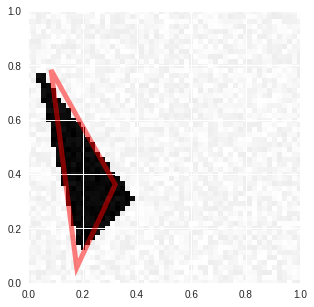

[0.17857544 0.0564159  0.32017398 0.36117372 0.08407217 0.78302205]
[0.18268838 0.11404042 0.36227032 0.29758231 0.02978994 0.76471819]


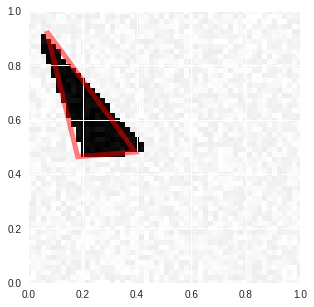

[0.39356023 0.48125306 0.18243417 0.4636993  0.06791018 0.92555135]
[0.40798921 0.48723003 0.19998412 0.46506003 0.0380623  0.90598046]
[[0.39356023 0.48125306 0.18243417 0.4636993  0.06791018 0.92555135]
 [0.7765391  0.47216105 0.5684382  0.98697263 0.14194968 0.9089502 ]
 [0.5680392  0.18327987 0.87881565 0.3623383  0.76379365 0.5969263 ]
 ...
 [0.456094   0.41641462 0.8286021  0.77207935 0.5488272  0.6543477 ]
 [0.78550637 0.55440265 0.6356315  0.70375156 0.26175478 0.3667484 ]
 [0.31951657 0.04273389 0.5011833  0.35097754 0.43524763 0.5750445 ]]


In [95]:
i = np.random.randint(300)
X_test = X_test.reshape((300, IMAGE_SIZE, IMAGE_SIZE, 1))
prediction = model.predict(X_test)
# visualize_prediction(X_test[i].reshape(IMAGE_SIZE,IMAGE_SIZE), np.array([0.25, 0.41, 0.41, 0.43, 0.65, 1]))
visualize_prediction(X_test[i].reshape(IMAGE_SIZE,IMAGE_SIZE), np.array(order(prediction[i])))
# visualize_prediction(X_test[i].reshape(IMAGE_SIZE,IMAGE_SIZE), Y_test[i])µ
print(prediction[i])
print(Y_test[i])

i = np.random.randint(1)
prediction = model.predict(X_train)
# visualize_prediction(X_test[i].reshape(IMAGE_SIZE,IMAGE_SIZE), np.array([0.25, 0.41, 0.41, 0.43, 0.65, 1]))
visualize_prediction(X_train[i].reshape(IMAGE_SIZE,IMAGE_SIZE), np.array(order(prediction[i])))
# visualize_prediction(X_test[i].reshape(IMAGE_SIZE,IMAGE_SIZE), Y_test[i])µ



## Image Denoising

In [0]:
def generate_a_rectangle(free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, np.random.randint(-150, 151)), generate_a_drawing(figsize, U, V, 0)


def generate_a_disk(free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, np.random.randint(-150, 151)), generate_a_drawing(figsize, U, V, 0)

def generate_a_triangle(free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, np.random.randint(-150, 151))
    imdata2 = generate_a_drawing(figsize, U, V, 0)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]],[imdata2, [U[0], V[0], U[1], V[1], U[2], V[2]]]
  
  
def generate_noisy_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples,im_size])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 100 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            Y[i],X[i] = generate_a_rectangle(free_location)
        elif category == 1: 
            Y[i],X[i] = generate_a_disk(free_location)
        else:
            [Y[i], Vy], [X[i], V] = generate_a_triangle(free_location)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]


In [0]:
x_train, x_train_noisy = generate_noisy_dataset_classification(600)
x_test, x_test_noisy = generate_noisy_dataset_classification(200)

Creating data:
0
100
200
300
400
500
Creating data:
0
100


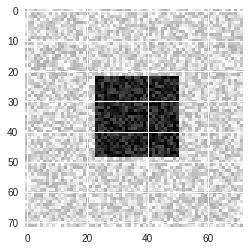

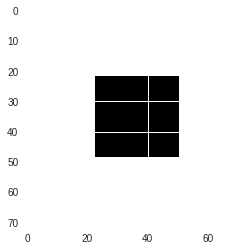

[255.65423557 326.26219899 314.05589204 ... 347.24469585 324.46627987
 263.9806873 ]
[255. 255. 255. ... 255. 255. 255.]


In [0]:
Rnoise, Rtrue = generate_a_rectangle()
plt.imshow(Rnoise.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.show()
plt.imshow(Rtrue.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.show()
print(Rnoise)
print(Rtrue)

In [0]:
%pylab inline
import os
import keras
import numpy as np
import pandas as pd
import keras.backend as K

from time import time
from sklearn.cluster import KMeans
from keras import callbacks
from keras.models import Model
from keras.optimizers import SGD
from keras.layers import Dense, Input, Conv2D, MaxPool2D, UpSampling2D
from keras.initializers import VarianceScaling
from keras.engine.topology import Layer, InputSpec

from scipy.misc import imread
from sklearn.metrics import accuracy_score, normalized_mutual_info_score

from keras.datasets import fashion_mnist

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['imread', 'time']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [0]:
# x_train_noisy = np.clip(x_train_noisy, 0., 1.)
# x_test_noisy = np.clip(x_test_noisy, 0., 1.)

In [0]:
x_train = np.reshape(x_train, (len(x_train), IMAGE_SIZE, IMAGE_SIZE, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), IMAGE_SIZE, IMAGE_SIZE, 1))  # adapt this if using `channels_first` image data format
x_train_noisy = np.reshape(x_train_noisy, (len(x_train), IMAGE_SIZE, IMAGE_SIZE, 1))  # adapt this if using `channels_first` image data format
x_test_noisy = np.reshape(x_test_noisy, (len(x_test), IMAGE_SIZE, IMAGE_SIZE, 1))  # adapt this if using `channels_first` image data format


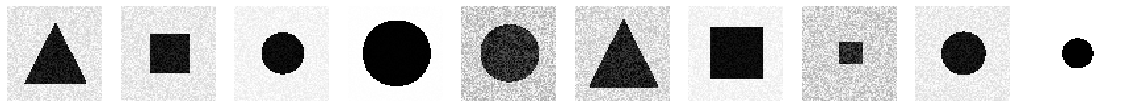

In [0]:
n = 10
plt.figure(figsize=(20, 10))
for i in range(1, n+1):
    ax = plt.subplot(1, n, i)
    plt.imshow(x_test_noisy[i-1].reshape(IMAGE_SIZE, IMAGE_SIZE))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [0]:
input_img = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (7, 7, 32)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [0]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=20,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Train on 600 samples, validate on 200 samples
Epoch 1/20
600/600 [==============================] - 14s 23ms/step - loss: 5.6038 - val_loss: 2.0078
Epoch 2/20
600/600 [==============================] - 13s 22ms/step - loss: 1.2908 - val_loss: 1.3664
Epoch 3/20
600/600 [==============================] - 13s 22ms/step - loss: 1.7104 - val_loss: 1.3858
Epoch 4/20
600/600 [==============================] - 13s 21ms/step - loss: 0.7498 - val_loss: 0.2495
Epoch 5/20
600/600 [==============================] - 13s 21ms/step - loss: 0.1552 - val_loss: 0.3401
Epoch 6/20
600/600 [==============================] - 13s 22ms/step - loss: 0.5878 - val_loss: 0.1345
Epoch 7/20
600/600 [==============================] - 13s 22ms/step - loss: 0.0949 - val_loss: 0.0650
Epoch 8/20
600/600 [==============================] - 13s 22ms/step - loss: 0.0574 - val_loss: 0.0528
Epoch 9/20
600/600 [==============================] - 13s 21ms/step - loss: 0.0503 - val_loss: 0.0511
Epoch 10/20
600/600 [===============

In [0]:
pred = autoencoder.predict(x_test_noisy)

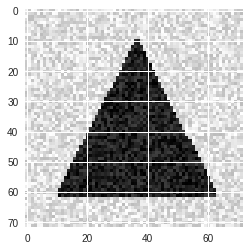

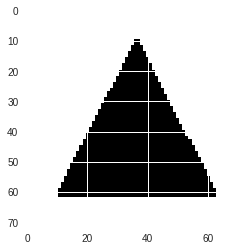

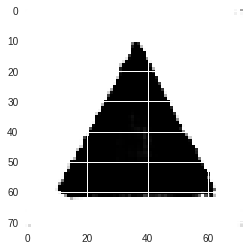

In [0]:
i = 5
plt.imshow(x_test_noisy[i].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.show()
plt.imshow(x_test[i].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.show()

plt.imshow(pred[i].reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')
plt.show()